# Project: Investigate a Dataset - NICS Database and US Census Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

#### Overview

The data used in this project (orignally sourced from this [Github](https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md)) comes from the FBI's National Instant Criminal Background Check System. This database is used to determine if an individual looking to buy firearms or explosives can legally do so. This data is generally considered to be the "best proxy for total gun sales in a given time period," although a one-to-one correlation cannot be made to a background check and a firearm purchase (jsvine [nics-firearm-background-checks](https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md#notes-on-the-data))

In addition, data from [US census data](https://www.census.gov/) was pulled to supplement analysis. This data includes some raw number for each of the 50 US states for facts like "median gross rent" or "total retail sales per capita."

#### Columns

This data ranges from November 1998 to September 2017. 

**NICS Data**

|Column Name | Significance |
|------------|--------------|
| `month` | Month + year for reported data |
| `state` | US State/territory reporting the number of background checks (55 unique values) |
| `permit` | Initial issuance of a permit to own a firearm |
| `permit_recheck` | Re-validation of a permit to own a firearm |
| `handgun` | A short-stocked weapon designed to be fired with a single hand/any combination of parts from which something matching that description can be assembled |
| `long_gun` | A weapon intended to be fired from the shoulder, ejects one projectile per trigger pull |
| `other` | Neither handguns, nor rifles/shotguns. Includes frames, receivers, silencers, National Firearms Act firearms, or firearms with a pistol grip that expel a shotgun shell |
| `multiple` | Multiple types of firearms selected (`handgun`,`long_gun`,`other`) |
| `admin` | Administrative checks that are for other authorized uses of the NICS |
| `prepawn_*` | (*Note: `*` indicates the column exists for handguns, long guns, and other firearms*) Background check requested by an officially-licensed Federal Firearms Licensee (FFL) in response to transferee seeking to pledge/pawn a firearm |
| `redemption_*` | FFL check request in response to transferee seeking to regain possession of a plegded/pawned firearm |
| `returned_*` | Requested by law enforcement/criminal justice before returning a firearm to an individual to ensure it is not prohibited |
| `rentals_*` (does not include `other`)| FFL check request in response to prospective firearm transferees attempting to possess a firearm loaned/rented and used off premises of the business |
| `private_sale_*` | FFL check request on prospective firearm transferees attempting to buy a firearm from a seller that is not an officially licensed FFL (background check via proxy) |
| `return_to_seller_*` | The source data ([here](https://www.fbi.gov/file-repository/cjis/nics_firearm_checks_-_month_year_by_state_type.pdf/view)) offers the same description for `private_sale`. If I had to presume what this is, I believe it may be for returns from a purchaser to a private seller of a firearm. I am not sure, though, and that is likely incorrect. |
| `totals` | Sum of values for all of the previously listed columns (besides `month` and `state`) |

**Census Data**

This data uses what was collected for the 2010 US Census plus estimates for the US population in 2017.

|Column Name | Significance |
|------------|--------------|
| `Fact` | Description of the statistic data was gathered for. |
| `Fact Note`  | Elaboration on the fact's data, 3 different notes. |
| `Alabama`  | Metric based on responses gathered from Alabama residents. Dollar value, percentage, count, etc. |
| (remaining 49 states) | ... |

### Question(s) for Analysis

Do states with higher populations (per the 2010 Census) have a proportionally larger amount of NICS look-ups? For example, if Arizona is about ~3x more populated than Arkansas, will there be ~3x more background checks?

This question also follows the same lines as determining the estimated "gun purchases" per capita, or at least NICS background checks. What does that look like when broken out to the different firearm types (`handgun`, `other`, `long gun`). Is the disparity between the three types generally the same across all of the states? I would assume a state like Rhode Island has a significantly smaller `long gun` background check percentage that somewhere like Wyoming, where hunting is much more prominent.

What is the general trend of NICS usage in respect to the percentage of popluation change? How closely does line follow the estimated population change when plotted on a line graph?
- Could do one for all 50 states, then 1 for each state.
  - Is it possible to overlay 50 lines? lol
- This might need to be like 50 unique graphs/line matrix from 2010-2016

Does median household income have a positive, negative, or no correlation with NICS background checks?

In [1106]:
# Import libraries and allow matplot lib inline backend usage of the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling


Here we will be looking at the datasets, characterizing them, then cleaning them.

### General Properties

In this section, we'll be perusing the data to see how "dirty" it is, as well as familiarize ourselves with it.

#### NICS Data

As with all of our data, we'll need to load it, this time by using the `pandas.read_csv()` method. We might as well take a peek at it, too, and see if anything sticks out as "dirty."

In [1107]:
df_nics = pd.read_csv('gun_data.csv')
df_nics.head(3)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394


One of the things I think I'd want to change is splitting the `month` column into one that is solely the month, and another for the year. It looks like it's a string, which won't be the easiest datatype to work with a date in.

In [1108]:
type(df_nics['month'][0])

str

After that, we should check if any rows are entirely null values or if we have any duplicates.

In [1109]:
print("Contains null rows:", df_nics.isnull().sum().all())
print("Contains duplicate rows:", df_nics.duplicated().any())

Contains null rows: False
Contains duplicate rows: False


Then, by using `.nunique()` we can see if any of the values for each column stick out or what we could use to inform our decisions. For example, I noticed that there are `55` values in the `state` column.

In [1110]:
df_nics.nunique()

month                          227
state                           55
permit                        5390
permit_recheck                 168
handgun                       7381
long_gun                      8350
other                         1226
multiple                      1387
admin                          499
prepawn_handgun                 90
prepawn_long_gun               133
prepawn_other                   16
redemption_handgun            1893
redemption_long_gun           2370
redemption_other                47
returned_handgun               237
returned_long_gun              113
returned_other                  34
rentals_handgun                  9
rentals_long_gun                 8
private_sale_handgun           152
private_sale_long_gun          136
private_sale_other              43
return_to_seller_handgun        17
return_to_seller_long_gun       17
return_to_seller_other           5
totals                       10218
dtype: int64

It looks like 5 of those values are territories or districts. If this data isn't going to be used at all for our analysis, it can probably just be removed.

They are:
- District of Columbia
- Virgin Islands
- Puerto Rico
- Guam
- Mariana Islands

In [1111]:
df_nics['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Mariana Islands', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

Using the `.info()` method against the NICS DataFrame shows that the data has a few concerning qualities.
- Of the total 12485 entries, only 4/27 columns lack null values.
  - Of my options for handling them (dropping, imputing, etc.), I am choosing to replace them with the value `0` so they don't have to be handled specially when I make the data type conversions mentioned in the next bullet point.
- There are some suboptimal choices for data types.
  - Nearly all of the numerical values are `float64`, but FFLs can't perform half of a background check, so there is no point in storing a decimal value if it will always be `.0`.

In [1112]:
df_nics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      12485 non-null  object 
 1   state                      12485 non-null  object 
 2   permit                     12461 non-null  float64
 3   permit_recheck             1100 non-null   float64
 4   handgun                    12465 non-null  float64
 5   long_gun                   12466 non-null  float64
 6   other                      5500 non-null   float64
 7   multiple                   12485 non-null  int64  
 8   admin                      12462 non-null  float64
 9   prepawn_handgun            10542 non-null  float64
 10  prepawn_long_gun           10540 non-null  float64
 11  prepawn_other              5115 non-null   float64
 12  redemption_handgun         10545 non-null  float64
 13  redemption_long_gun        10544 non-null  flo

#### Census Data

Now we'll load up the US Census data and run through a similar process in exploring the data's properties.

First, we'll see what it generally looks like.

In [1113]:
df_census = pd.read_csv('US_Census_Data.csv')
df_census.head(3)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%


Already, I can see that there are null values. In fact, at least 5 of the 85 "entries" do not show up under a column per `.info()`. I'm also not a huge fan of the states being their own column. The column names are capitalized, which isn't inherently a bad thing, however `Fact Note` has a space in the middle of it. 

I also see that all of the data types are `object`, which will need to be changed before the data can be analyzed.

If this were a database, I'd probably make the sacrifice of having 50 records per `Fact` so that the only colummns are `Fact`, `Fact Note`, `State`, and `Value/Quantity`. I'd then break out a few more tables for states, facts, and fact notes to get it to third normal form.

Having the states in separate columns means I can't group by `state` as gracefully, too, which may make some analytics and visuals awkward to make. Leaving it how it is now does simplify our lives, and the data should still be accessible. 

In [1114]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Fact            80 non-null     object
 1   Fact Note       28 non-null     object
 2   Alabama         65 non-null     object
 3   Alaska          65 non-null     object
 4   Arizona         65 non-null     object
 5   Arkansas        65 non-null     object
 6   California      65 non-null     object
 7   Colorado        65 non-null     object
 8   Connecticut     65 non-null     object
 9   Delaware        65 non-null     object
 10  Florida         65 non-null     object
 11  Georgia         65 non-null     object
 12  Hawaii          65 non-null     object
 13  Idaho           65 non-null     object
 14  Illinois        65 non-null     object
 15  Indiana         65 non-null     object
 16  Iowa            65 non-null     object
 17  Kansas          65 non-null     object
 18  Kentucky    

One of the outliers is `Fact Note`, as it has only 28 non-null values when there are 65 data points for each state and... 80 facts? We'll worry about that next. Anyway, should we care about the `Fact Note` column? What non-null values does it have in the first place?

In [1115]:
df_census['Fact Note'].value_counts()

Fact Note
(c)                                                                                                                                                                                                                                            6
(a)                                                                                                                                                                                                                                            5
Includes data not distributed by county.                                                                                                                                                                                                       5
(b)                                                                                                                                                                                                                                            1
Includes persons reporting

It looks like these are probably good caveats to consider before we draw conclusions, but they will not be useful for analysis of the data. I will be dropping `Fact Notes`

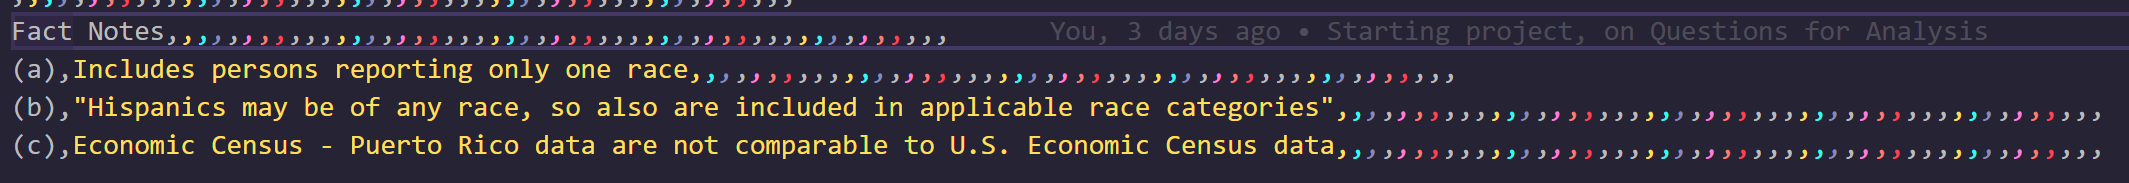

Now for those 80 facts, what's up with those?

In [1116]:
df_census['Fact'].unique()

array(['Population estimates, July 1, 2016,  (V2016)',
       'Population estimates base, April 1, 2010,  (V2016)',
       'Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)',
       'Population, Census, April 1, 2010',
       'Persons under 5 years, percent, July 1, 2016,  (V2016)',
       'Persons under 5 years, percent, April 1, 2010',
       'Persons under 18 years, percent, July 1, 2016,  (V2016)',
       'Persons under 18 years, percent, April 1, 2010',
       'Persons 65 years and over, percent,  July 1, 2016,  (V2016)',
       'Persons 65 years and over, percent, April 1, 2010',
       'Female persons, percent,  July 1, 2016,  (V2016)',
       'Female persons, percent, April 1, 2010',
       'White alone, percent, July 1, 2016,  (V2016)',
       'Black or African American alone, percent, July 1, 2016,  (V2016)',
       'American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)',
       'Asian alone, percent, July 1, 2016,  (V20

Some of these facts don't look the same as the others, such as `FN` and `Z`. Those are apparently value flags. I'm not sure they will be needed, so we'll probably drop them.

The last 17 items of the list are what we will want to remove.

In [1117]:
[df_census['Fact'] == "Z"]

[0     False
 1     False
 2     False
 3     False
 4     False
       ...  
 80    False
 81    False
 82    False
 83    False
 84     True
 Name: Fact, Length: 85, dtype: bool]

With the CSV column highlighter I have installed, we can look at all of the left-most grey text and know it falls under `Fact`. It looks like some notes or a key of sorts was thrown into the bottom of the data. We'll make sure those are all gone when we remove all null values.

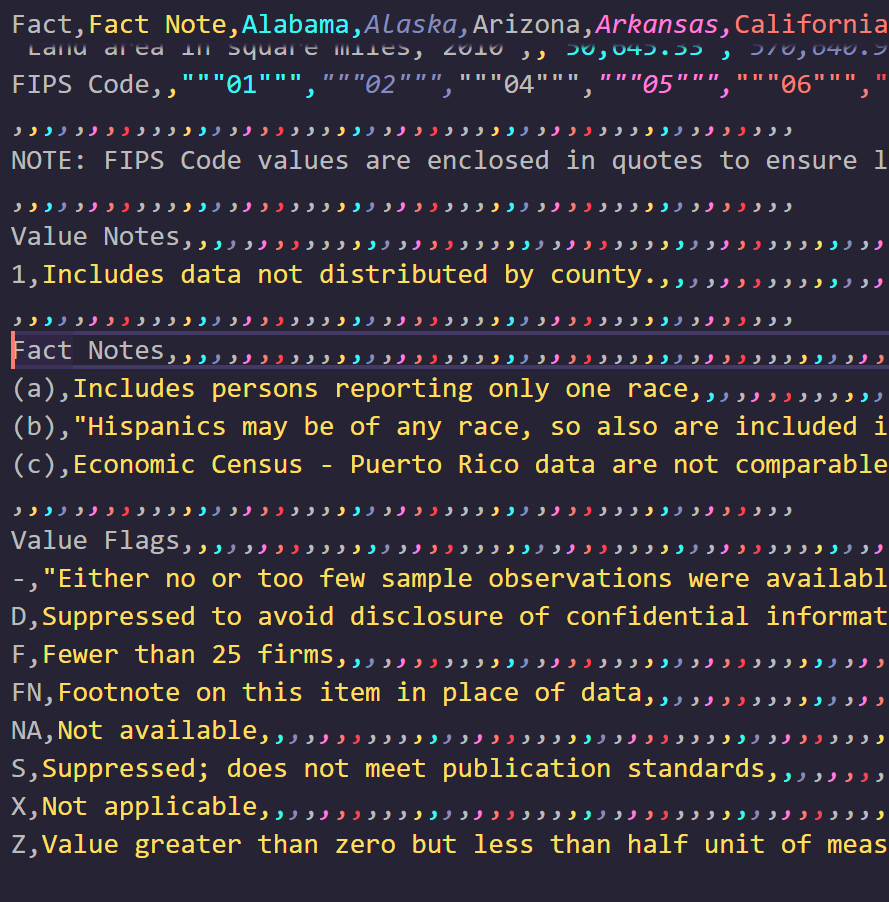

This quirk in the data also explains why we have null values in all of the state columns.

In [1118]:
df_census.tail()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
80,FN,Footnote on this item in place of data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,Not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,S,Suppressed; does not meet publication standards,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,X,Not applicable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Z,Value greater than zero but less than half uni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We should probably double check if there are any null value in rows with actual data.

We can do that by:
1. Taking a slice of all of the states with `.iloc[2:end]`, plus the window of data we wish to analyze (0:64 exclusive).
2. Check if those values are not null (returns boolean)
  a. Check if all booleans are the same for each state's values with `.all()`
  b. Do the same, but for all states by nesting it all under another `.all()`

In [1119]:
# We'll use a similar technique to drop all of the data we don't want
(df_census.iloc[:, 2:][:64]).notnull().all().all()

np.True_

### Data Cleaning

 

#### NICS Data

To tidy up this data and get it how I plan to work with it, I will...
- Replacing all null values
  - One potential issue with this, besides that we don't _know_ `0` was reported for those fields instead of that data was just not collected, 
  
- Change all numeric types to `int32` to reduce memory usage.
- Drop 5 of the 55 values for `state`, leaving just the 50 US States. 
  - The US Census data for this project does not have anything for the territories that the NICS data has:
    - `['District of Columbia', 'Virgin Islands', 'Puerto Rico', 'Guam', 'Mariana Islands']`
- Split the current `month` string (`YYYY-mm`) into 2 separate columns of integers, one for `year` and the other for `month`.

In [1120]:
# Replace all null values with 0 to prevent errors when typecasting
df_nics.fillna(0, inplace=True)

Here, I'll be removing the `state` values in the NICS data that do not show up in the US Census Data.

In [1121]:
len(df_nics.state.unique())

55

There are 227 rows of data for each state. By removing the 5 territories, we should reduce our total number of records down to 11350.

In [1122]:
a = 12485 - (227 * 5)
print(a)

11350


In [1123]:
drop_states = ['District of Columbia', 'Virgin Islands', 'Puerto Rico', 'Guam', 'Mariana Islands']
df_nics['state'].value_counts()


state
Alabama                 227
Alaska                  227
Arizona                 227
Arkansas                227
California              227
Colorado                227
Connecticut             227
Delaware                227
District of Columbia    227
Florida                 227
Georgia                 227
Guam                    227
Hawaii                  227
Idaho                   227
Illinois                227
Indiana                 227
Iowa                    227
Kansas                  227
Kentucky                227
Louisiana               227
Maine                   227
Mariana Islands         227
Maryland                227
Massachusetts           227
Michigan                227
Minnesota               227
Mississippi             227
Missouri                227
Montana                 227
Nebraska                227
Nevada                  227
New Hampshire           227
New Jersey              227
New Mexico              227
New York                227
North Carolina

After dropping the locations we do not want, we can validate our results. Now we should validate that there are still 227 for each of the remaining 50 states.

In [1124]:
drop_states = ['District of Columbia', 'Virgin Islands', 'Puerto Rico', 'Guam', 'Mariana Islands']

for state in drop_states:
    drops = df_nics[df_nics['state'] == state].index

    for i in drops:
        df_nics.drop(index=i, inplace=True)

states = df_nics['state'].unique()

# Printing our validation results
print("Length is:", len(states))
print("All states still have 227 records:", (df_nics['state'].value_counts().values == 227).all())
print("Values are:", states)

Length is: 50
All states still have 227 records: True
Values are: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [1125]:
# Extract sequence of 4 digits, followed by a dash (not captured), then 2 digits
df_date = df_nics['month'].str.extract('(\d{4})-(\d{2})').astype('int16')

df_nics['year'] = df_date[0]
df_nics['month'] = df_date[1]

# This DataFrame will not be used later and can be destroyed
del df_date

Adding the new `year` column will append it to the end/right of the DataFrame.This is somewhat inconvenient when trying to view the data with `.head()`

In [1126]:
# To reorder, first we will make a list of columns with 'year' at the start
# Then we will use the .reindex() method to set the columns to the new order we want
df_nics = df_nics.reindex(columns=['year'] + list(df_nics.columns)[:-1])
df_nics.head(1)

,year,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017,9,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019


In [1127]:
df_nics.tail(1)

,year,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
12484,1998,11,Wyoming,8.0,0.0,45.0,49.0,0.0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107


The `head` and `tail` outputs are expected, showing us our most recent data and our oldest data, sorted alphabetically by `state` (hence, Alabama at the top and Wyoming at the bottom).

In [1128]:
numeric_cols = df_nics.columns.to_list()[3:]  # permit --> totals

# Re-cast columns to 32-bit integer
for col in numeric_cols:
    df_nics[col] = df_nics[col].astype('int32')

Now we should only have 1 string (`object`) column, 2 `int16` columns, and the rest should be `int32`.

In [1129]:
df_nics.dtypes.value_counts()

int32     25
int16      2
object     1
Name: count, dtype: int64

To recap, we:
- Replaced all null values with `0`.
- Dropped rows with `state` values that did not appear in the Census data.
- Split the old `month` string (format: `"YYYY-mm"`) into 2 numeric columns, `year` and `month`.
- Cast all other numeric columns to `int32`, as none of their values are >2^32.

Now that the NICS data is cleaned up, we'll write it to a new CSV and move onto the US Census data.

In [1130]:
df_nics.to_csv('clean_gun_data.csv', index=False)

#### Census Data

For the Census data, we do the following cleaning actions:
- Trim away the bottom notes portion
- Drop the `Fact Notes` column and lowering the case of the `Fact` column header.
- Remove spaces from state columns (i.e. `New Hampshire`).
- Correct the data types under the state columns, as only raw numbers, dollar amounts, and percentages are being stored.
  - We will have to remove special characters first.

First, well select only the data we want and overwrite the DataFrame with it.

In [1131]:
df_census = df_census[:64]
df_census.tail(1)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
63,"Land area in square miles, 2010",NaN,"50,645.33","570,640.95","113,594.08","52,035.48","155,779.22","103,641.89","4,842.36","1,948.54",...,75811,41234.9,"261,231.71","82,169.62","9,216.66","39,490.09","66,455.52","24,038.21","54,157.80","97,093.14"


Then, we'll drop the `Fact Note` column and make `Fact` lowercase.

In [1132]:
df_census.drop(columns='Fact Note', inplace=True)


Now we will make the columns lowercase and replace spaces with underscores.

In [1133]:
'''
remove_spaces = df_census.columns.tolist()


for col in remove_spaces:
    tmp = col.replace(' ', '_').lower()
    df_census.rename(columns={col: tmp}, inplace=True)

df_census.columns
'''

"\nremove_spaces = df_census.columns.tolist()\n\n\nfor col in remove_spaces:\n    tmp = col.replace(' ', '_').lower()\n    df_census.rename(columns={col: tmp}, inplace=True)\n\ndf_census.columns\n"

With that done, now we can remove the special characters in some of the strings and convert everything to a numeric data type. Looking through the data, we can see that the only special charactesr are `,`, `$`, and `%`, which is what we'll target. 

There are also a `'D'`, `'FN'`, and `'Z'` values, which indicate either the information was suppressed to prevent confidential information from being leaked, the data was placed elsewhere in the source document, or the value is too small to represent. For those, we'll just impute them with the mean of the row to keep things simple and have the most minimal impact on the rest of the data. This does mean that we will have some inaccuracies, however this would be better than setting the values to `0` or null.

Finally, since we are already accessing the columns, we might as well just convert them to `float64`. This will preserve the accuracy, because if we do smaller than 64-bit floats, the values will be modified to be in scientific notation, which may drop some digits.

In [1134]:
for col in df_census.columns[1:]:  # all columns except for fact
    df_census[col] = df_census[col].replace(regex='([,$%])', value='')

    # set D, FN, and Z values to None, then replace with row's mean
    df_census[col] = df_census[col].replace(regex='([DZ(FN)])', value=None)
    df_census[col] = df_census[col].fillna(float(df_census[col].astype('float32').mean()))
    df_census[col] = df_census[col].astype('float64')

Our only two data types should be `float64` and `object` (string) now.

In [1135]:
df_census.dtypes.value_counts()

float64    50
object      1
Name: count, dtype: int64

Our data has been all tidied up, so lets write it out to a new CSV in case we want to use it later.

In [1136]:
df_census.to_csv('clean_census_data.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. Remember to utilize the visualizations that the pandas library already has available.



> **Tip**: Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.

### Is There a Correlation Between Median Household Income and Background Checks?

Does median household income have a positive, negative, or no correlation with NICS background checks? Compared to states with lower median income, how much more or less are states with higher median household incomes reporting background checks?

Lets try making a graph and seeing what it looks like. Each state will represent it's own point on a scatterplot. The median household income will be the x-axis while the y-axis will be the NICS lookups.

In [1137]:
# Load clean data
df_nics = pd.read_csv('clean_gun_data.csv')
df_census = pd.read_csv('clean_census_data.csv')

Median household income (in 2015 dollars), 2011-2015

We'll make another DataFrame for the NICS data that has the sum of all of the states values per year, from the years 2011-2015.

In [1138]:
def find_index(df, regex_capture_group):
    return df.str.extractall(regex_capture_group)[0].index.to_list()

# Median household income (in 2015 dollars), 2011-2015
income_idx = find_index(df_census.Fact, "(.*Median household income.*)")[0][0]

df_hh_inc = df_census.iloc[income_idx][1:]

df_hh_inc = df_hh_inc.to_frame()

df_hh_inc.rename(columns={47: 'median_hh_inc'}, inplace=True)
df_hh_inc.head(2)

,median_hh_inc
Alabama,43623.0
Alaska,72515.0


For the other NICS DataFrame, we'll first get all records from 2011-2015 and group them by `state` and `year`. Then, we will sum all of the month's values together, leaving just one value per year, 4 values per state.

In [1147]:
# 1. query for all records between years 2011-2015
# 2. group the records by state, then year
# 3. aggregate each year's totals with summation
df_2011_2015 = df_nics[df_nics['year'].between(2011, 2015, inclusive='both')] \
    .groupby(by=['state', 'year']) \
        .agg({'totals': 'sum'})

df_2011_2015.head(10)

totals
state   year        
Alabama 2011  336102
        2012  431356
        2013  563880
        2014  621305
        2015  737509
Alaska  2011   70198
        2012   85342
        2013   93405
        2014   87623
        2015   85621

Now to follow the logic of the Census fact (median of data from 2011-2015 (assumed inclusive)), we will get the median value between all of the years, reducing it down to a single value per state.

In [1140]:
df_nics_med = df_2011_2015.groupby('state').median()

df_nics_med.rename(columns={"totals": "median_totals"}, inplace=True)
df_nics_med.head(2)  # Confirming that these values show up in the output above

,median_totals
state,
Alabama,497618.0
Alaska,86482.5


When we created the two other DataFrames, the indexes were set to the 50 states. This is helpful as we can perform a `.join()` with the two DataFrames and they'll, well, join.

In [1141]:
df_combined = df_hh_inc.join(df_nics_med)  # Joining based off of index (state)

df_combined.head(2)

,median_hh_inc,median_totals
Alabama,43623.0,497618.0
Alaska,72515.0,86482.5


By graphing what we have now, we can see Kentucky is a major outlier.

One of the reasons this is so is because they run checks on concealed carry license holders every month. This means that nearly 2.5 million checks are done in the span of 4 years.

In [ ]:
df_combined.loc["Kentucky"]  # Values in graph below

median_hh_inc      43740.0
median_totals    2386508.0
Name: Kentucky, dtype: object

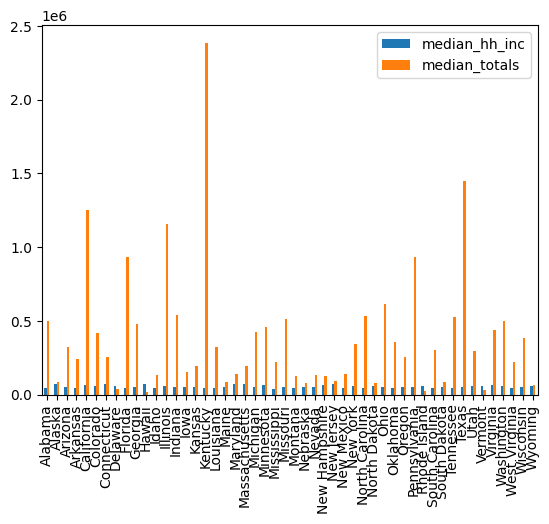

In [1143]:
df_combined.plot(kind='bar');

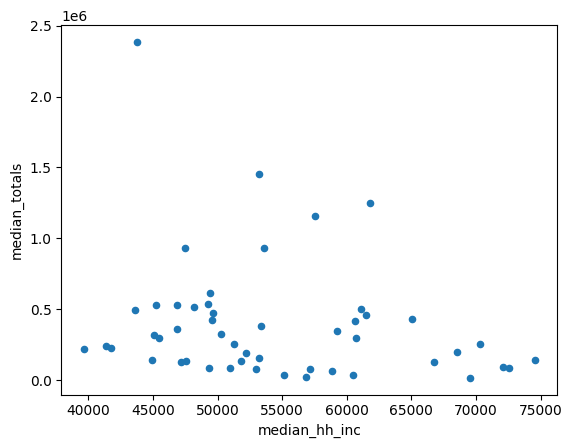

In [1144]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
# TODO: scatterplot x=income, y=nics -- good luck figuring this out

df_combined.plot(kind='scatter', x='median_hh_inc', y='median_totals');

### Research Question 2  (Replace this header name!)

In [1145]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.

> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should see output that starts with `NbConvertApp] Converting notebook`, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [1146]:
# Running this cell will execute a bash command to convert this notebook to an .html file
# !python -m nbconvert --to html Investigate_a_Dataset.ipynb